In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

import gc

from sklearn.model_selection import train_test_split, StratifiedKFold

import pickle

from sklearn.metrics import roc_curve, auc, roc_auc_score

from glove import Corpus, Glove

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from utils import *
from features import *
from trainer import *

from datasets import LikesFeaturesDataset
from networks import NeuralNetFeaturesConv
from clr import CyclicLR

In [4]:
def auc(labels, scores):
    if len(labels) > sum(labels) > 0:
        return roc_auc_score(labels, scores)

    return np.nan

In [5]:
np.random.seed(42)
tqdm_notebook.pandas()

In [15]:
glove = Glove.load('glove_300_mc4_ink_w10.model')
word2index = glove.dictionary
embeddings = glove.word_vectors

max_seq_len = 64 # max number of words in a question to use
embed_size = embeddings.shape[1]

In [6]:
input_path = 'input/'

TRAIN_TEXTS = os.path.join(input_path, 'texts', 'textsTrain')
TRAIN_META = os.path.join(input_path, 'textsTrain')

In [7]:
seed_everything(42)

In [8]:
meta = read_metadata(TRAIN_META)
texts = read_texts(TRAIN_TEXTS, disable_tqdm=False, tqdm_module=tqdm_notebook)

In [9]:
meta['liked'] = [float('Liked' in v) for v in meta.feedback.values]

meta['audit_timestamp'] = pd.to_datetime(meta['audit_timestamp'], unit='ms')
meta['audit_hour'] = [v.hour for v in meta.audit_timestamp]

In [10]:
custom_onehot(meta, 'instanceId_objectType')
custom_onehot(meta, 'audit_clientType')
custom_onehot(meta, 'audit_hour')

In [11]:
bad_objects = get_bad_logs(texts)
texts = texts[[not(v in bad_objects) for v in texts.objectId.values]]
meta = meta[[not(v in bad_objects) for v in meta.instanceId_objectId.values]]

In [16]:
texts['preprocessed'] = [np.array([convert_single(w) for w in seq]) for seq in texts['preprocessed'].values]
texts['preprocessed_idx'] = [get_embedding_indexes(word2index, seq, unknown_token='<unk>') for seq in texts.preprocessed.values]

texts['text_len'] = [len(seq) for seq in texts.text]
texts['token_num'] = [len(seq) for seq in texts.preprocessed]

In [17]:
texts.set_index('objectId', inplace=True)

meta.rename(columns={'instanceId_objectId': 'objectId'}, inplace=True)
meta = meta.join(texts, on='objectId')

In [18]:
stat_features = ['instanceId_objectType_Photo', 'instanceId_objectType_Post', 'instanceId_objectType_Video', 
                'audit_clientType_API', 'audit_clientType_MOB', 'audit_clientType_WEB',
                'audit_hour_0', 'audit_hour_1','audit_hour_2', 'audit_hour_3', 'audit_hour_4', 'audit_hour_5',
                'audit_hour_6', 'audit_hour_7', 'audit_hour_8', 'audit_hour_9','audit_hour_10', 'audit_hour_11',
                'audit_hour_12', 'audit_hour_13', 'audit_hour_14', 'audit_hour_15', 'audit_hour_16', 'audit_hour_17',
                'audit_hour_18', 'audit_hour_19', 'audit_hour_20', 'audit_hour_21', 'audit_hour_22', 'audit_hour_23',
                'text_len', 'token_num']

In [19]:
data_train, data_test = train_test_split(meta, test_size=0.2)

In [20]:
# dont know why but at first creation of module I get cuDNN error.
# however, on second creation and further its ok

try:
    model = NeuralNetFeaturesConv(embeddings, max_seq_len=max_seq_len, embed_size=embed_size,
                                  hidden_size=30, n_features=len(stat_features), train_embed=False)
    model.cuda()
except:
    del model
    gc.collect()

In [21]:
batch_size = 512*4
kwargs = {'num_workers': 4, 'pin_memory': True}

train_dataset = LikesFeaturesDataset(data_train, stat_features, max_seq_len, idx_col='preprocessed_idx') 
test_dataset = LikesFeaturesDataset(data_test, stat_features, max_seq_len, idx_col='preprocessed_idx')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

model = NeuralNetFeaturesConv(embeddings,  max_seq_len=max_seq_len, embed_size=embed_size,
                              hidden_size=64, n_features=len(stat_features),train_embed=False)
model.cuda()

loss_fn = torch.nn.BCELoss()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = CyclicLR(optimizer, step_size=10*len(train_loader), mode='exp_range', gamma=0.99999)
n_epochs = 5

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = CyclicLR(optimizer, step_size=10*len(train_loader), mode='exp_range', gamma=0.99999)

lr_list = list()

for _ in range(20*len(train_loader)):
    lr_list.append(scheduler.get_lr())
    
    scheduler.batch_step()

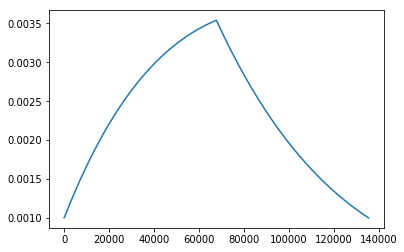

In [46]:
# Learning rate during training
plt.plot(lr_list)

In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = CyclicLR(optimizer, step_size=10*len(train_loader), mode='exp_range', gamma=0.99999)

In [22]:
# for this notebook I quickly trained nn for only 5 epochs.  
# However, training for 20 epochs provided a little better results but took much more time.
train_history = list()
val_history = list()
roc_history = list()

for epoch in tqdm.tnrange(n_epochs):
    train_loss = train_epoch(train_loader, model, loss_fn, optimizer, scheduler, tqdm_module=tqdm_notebook)
    val_loss = test_epoch(test_loader, model, loss_fn)
        
    train_history.append(train_loss)
    val_history.append(val_loss)    

In [25]:
logits = predict(model, test_loader).flatten()
data_test['scores'] = logits

/home/vladka/anaconda3/envs/mlboot_bert/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
roc_loss = data_test.groupby('instanceId_userId').apply(lambda y: auc(y.liked.values, y.scores.values)).dropna().mean()

In [28]:
print(roc_loss)

0.6482126564531246


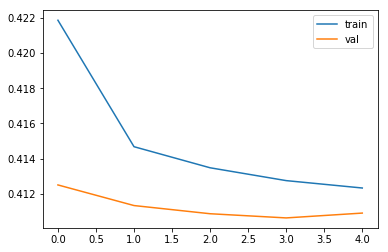

In [31]:
plt.plot(train_history, label='train')
plt.plot(val_history, label='val')

plt.legend()